In [1]:
import numpy as np
import pandas as pd
import skimage.io as sio
import matplotlib.pyplot as plt

import diff_classifier.aws as aws
import diff_register.register as reg
import diff_register.im_process as imp

c:\users\enuser\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


One of the key features of diff_register is extracting cellular properties from input images. This demo notebook will show how to extract cellular properties without incorporating any accompanying multi-particle tracking datasets.

As an example dataset, I have included a large tif image of a DAPI stain in a brain slice from which we would like to extract cellular features. As DAPI stains cell nuclei, and cell nuclei are round, the resulting branch/process features won't be very informative, but users can see how they would be used

In [148]:
cprefix = 'P35_PAM_Iba_tilescan_v2_L_thal'
cfile = 'C:/Users/enuser/Downloads/P35/{}.tif'.format(cprefix)
newprefix = 'P35_PAM_L_thal'
newfile = '{}.tif'.format(newprefix)
#cfolder = 'Tissue_Studies/04_23_18_Registration_Test'

#aws.download_s3('{}/{}'.format(cfolder, cfile), cfile, bucket_name='ccurtis.data')

cim = sio.imread(cfile)

pxrat_cells = 1.24
#pxrat_traj = 0.16
#dim_traj = 2048
#dim_cells = int(np.round(dim_traj*pxrat_traj/pxrat_cells, decimals=0))

In [149]:
cimm = cim[1,:,:]

Users can use the skimage.io toolbox to preview the image. This tilescan image is fairly large. If users want to view a subset of the image, they can use the indices of the image to zoom in.

c:\users\enuser\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\users\enuser\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


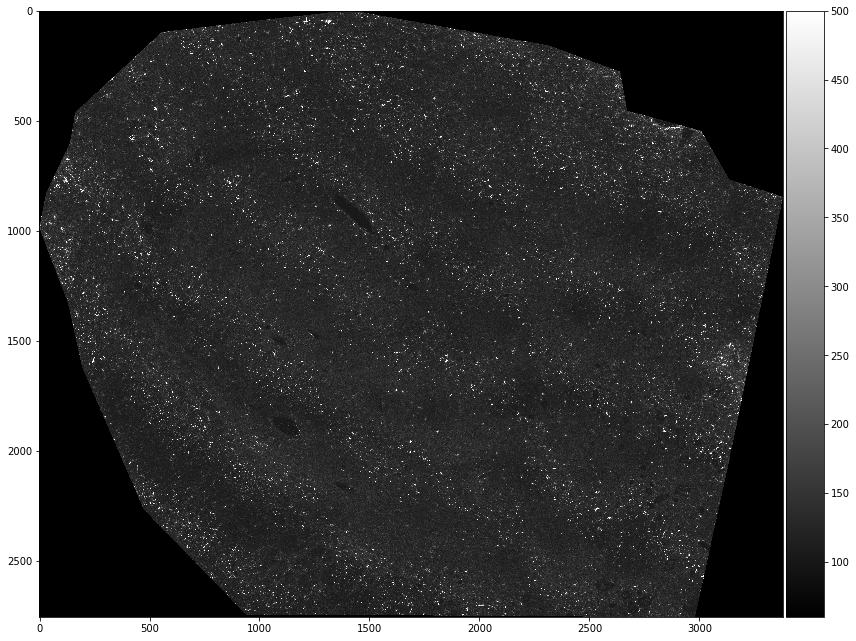

In [150]:
plt.subplots(figsize=(12,12))
sio.imshow(cimm, vmin=60, vmax=500, cmap='gray')

In [151]:
sio.imsave(newfile, cimm)

c:\users\enuser\anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: P35_PAM_L_thal.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


diff_register can be run directly on large tilescans, but it is a good idea to optimize image processing parameters on a smaller image first. Try running skeleton_image on the small image from above.

c:\users\enuser\anaconda3\lib\site-packages\skimage\util\dtype.py:118: UserWarning: Possible sign loss when converting negative image of type int32 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
c:\users\enuser\anaconda3\lib\site-packages\skimage\util\dtype.py:171: UserWarning: Downcasting int32 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


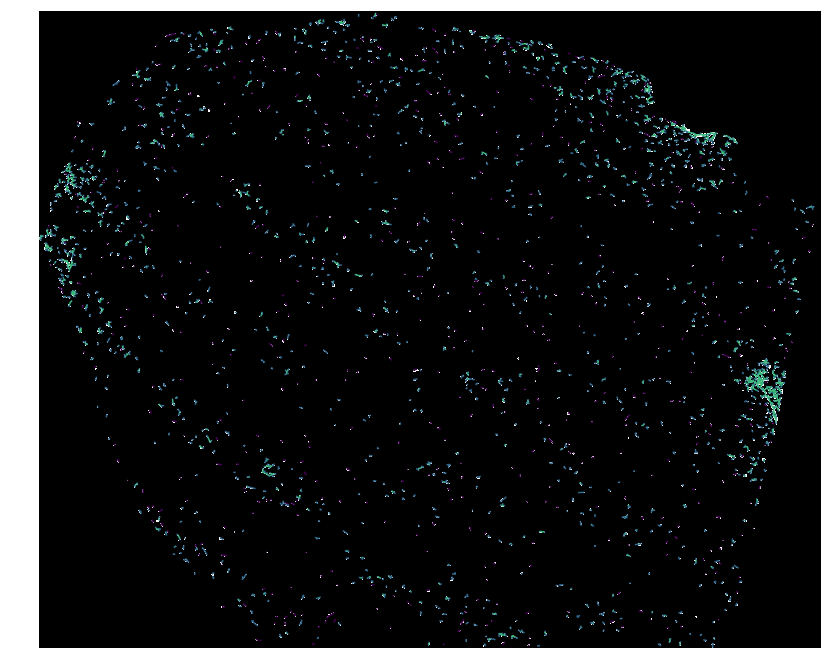

In [153]:
skel = imp.skeleton_image('.', newfile, 10, 35, tofilt=True, show=True, imname='skel_{}'.format(newfile),
                   channel=None, figsize=(14,14), ajar=False, close=False)

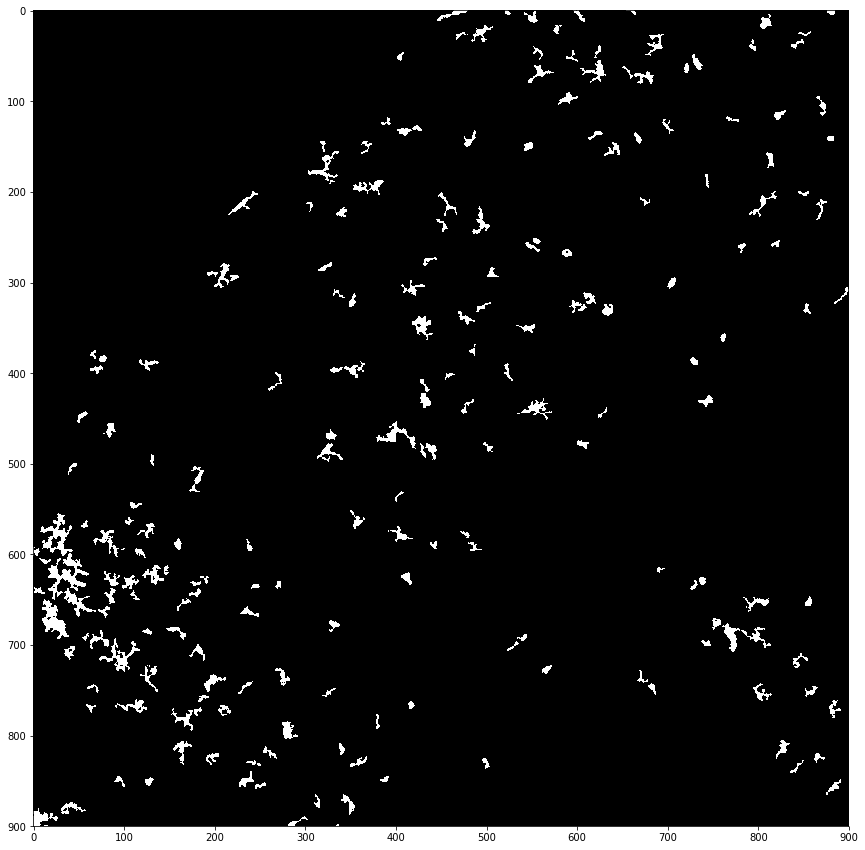

In [154]:
plt.subplots(figsize=(15,15))
plt.imshow(skel.shortim[100:1000, 100:1000], cmap='gray')

In [155]:
Dfeatures = imp.mglia_features(skel, umppx=1.24)

In [156]:
Dfeatures.describe()

,X,Y,area,average_branch,eccentricity,label,main_branch,perimeter,solidity,total_branches
count,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000
mean,1563.612105,2120.527133,139.619751,10.987541,0.835892,10511.889946,15.158940,65.800503,0.679660,3.784057
std,948.297015,1143.386476,342.085389,6.235501,0.128239,6748.534552,6.840168,114.609420,0.138261,9.582928
min,20.065455,8.570777,53.816000,0.000000,0.171317,1.000000,0.000000,23.948999,0.315291,0.000000
25%,726.882609,1145.525405,69.192000,6.997814,0.779818,4260.000000,10.452925,37.163498,0.578947,1.000000
50%,1485.100308,2167.266364,93.793600,9.042444,0.875441,10299.000000,13.940874,48.022623,0.678571,3.000000
75%,2330.037500,3127.476825,146.072000,13.214499,0.927542,16243.000000,18.315719,71.245247,0.777778,5.000000
max,3406.457143,4147.104390,12127.051200,59.784372,0.993217,22667.000000,59.784372,4144.472038,1.000000,356.000000


In [157]:
Dfeatures['hemisphere'] = 'L'
Dfeatures['region'] = 'thal'

In [158]:
Dfeatures.to_csv('{}.csv'.format(newprefix))

The output of mglia_features is a pandas dataframe containing all the features of individual cells. Users can perform analyses directly on this data. For example, users can calculate average area of a cell, or the total number of cells:

In [17]:
print('Average cell nuclei area: {} +/- {}'.format(np.round(np.mean(Dfeatures['area']), 1),
                                                   np.round(np.std(Dfeatures['area']), 1)))
print('Cell count : {}'.format(Dfeatures.shape[0]))

Average cell nuclei area: 142.0 +/- 227.5
Cell count : 450


In [161]:
hemis = ['R', 'L']
regs = ['cor', 'hipp', 'thal']
types = ['LPS', 'PAM']
count = 0

for typ in types:
    for hemi in hemis:
        for reg in regs:
            filename = 'C:/Users/enuser/Downloads/P35/P35_{}_{}_{}.csv'.format(typ, hemi, reg)
            mglia = pd.read_csv(filename)
            mglia['Injury'] = typ
            mglia['Subgroup'] = typ + ' ' + hemi
            if count == 0:
                mglias = mglia
            else:
                mglias = pd.concat((mglias, mglia))
            count = count + 1

In [ ]:
'typ' + 'typ'

In [160]:
mglias.describe(percentiles=[0.05, 0.95])

,Unnamed: 0,X,Y,area,average_branch,eccentricity,label,main_branch,perimeter,solidity,total_branches
count,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000
mean,517.450296,1226.210891,1963.772539,140.456949,11.197145,0.830508,5538.043643,15.209164,64.124658,0.698403,3.485501
std,386.801689,1040.235163,1187.754171,222.554897,6.922166,0.132436,4570.290369,10.443657,77.986066,0.140247,5.595131
min,0.000000,4.527442,3.847835,53.816000,0.000000,0.000000,1.000000,0.000000,20.911312,0.265113,0.000000
5%,42.500000,133.621109,246.271515,55.353600,4.747250,0.559266,383.000000,6.153874,28.908999,0.467059,1.000000
50%,432.000000,990.107368,1877.608000,96.868800,9.311769,0.870676,4469.000000,13.940874,47.809873,0.696203,3.000000
95%,1330.500000,3109.508952,4137.593231,329.046400,23.435374,0.969319,15066.000000,27.881749,139.775712,0.928571,9.000000
max,1680.000000,5673.971892,5672.508276,12127.051200,283.960000,0.999992,22667.000000,758.117123,4144.472038,1.000000,356.000000


In [ ]:
mglias.columns

In [ ]:
#PAM L cor
5898214

#PAM R cor
12380886

#PAM L hipp
1187018

#Pam R hipp
2940483

#PAM L thal
5303738

#PAM R thal
2708496

#LPS L cor
2779084

#LPS R cor
4241960

#LPS L hipp
2689968

#LPS R hipp
2383188

#LPS L thal
1034764

#LPS R thal
1845119

In [162]:
test = np.array([3744388, 3014908, 4743556, 4010954, 2308286, 5985827, 2586132, 1344411, 3903091, 5385747, 4583885, 7415105])
test*1.24

array([4643041.12, 3738485.92, 5882009.44, 4973582.96, 2862274.64,
       7422425.48, 3206803.68, 1667069.64, 4839832.84, 6678326.28,
       5684017.4 , 9194730.2 ])

In [ ]:
mglias.size

In [185]:
nPL = [0, 2, 4]
nPR = [1, 3, 5]
nLL = [6, 8, 10]
nLR = [7, 9, 11]
dens = [0]*4
a = 0
counter = 0
for typ in types:
    b = 0
    for hemi in hemis:
        nums = [6*a+3*b, 6*a+3*b+1, 6*a+3*b+2]
        areas = np.sum(test[nums])
        dens[counter] = mglias[(mglias['hemisphere']==hemi) & (mglias['Injury']==typ)].size/areas*1000
        print(dens)
        counter = counter + 1
        print('{} and {} and {}'.format(typ, hemi, nums))
        b = 0 + 1
    a = a + 1
dens = np.array(dens)

[3.504087508037137, 0, 0, 0]
LPS and R and [0, 1, 2]
[3.504087508037137, 2.1925114263904453, 0, 0]
LPS and L and [3, 4, 5]
[3.504087508037137, 2.1925114263904453, 5.629315844983312, 0]
PAM and R and [6, 7, 8]
[3.504087508037137, 2.1925114263904453, 5.629315844983312, 3.675810568776508]
PAM and L and [9, 10, 11]


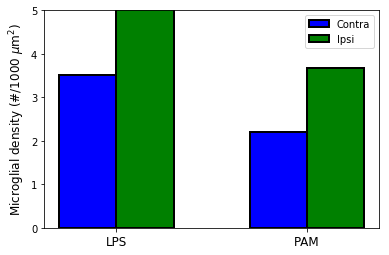

In [187]:
N = 2

fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.3         # the width of the bars
p1 = ax.bar(ind, dens[0:2], width, color='b', bottom=0, edgecolor='k', linewidth=2)
p2 = ax.bar(ind + width, dens[2:4], width, color='g', bottom=0, edgecolor='k', linewidth=2)

ax.set_ylabel(r'Microglial density (#/1000 $\mu$' + r'm$^2$)', fontsize=12)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('LPS', 'PAM'), fontsize=12)
ax.set_ylim([0, 5])

ax.legend((p1[0], p2[0]), ('Contra', 'Ipsi'))

plt.show()

In [184]:
dens[[1,2]]

TypeError: list indices must be integers or slices, not list

In [168]:
mPAMR, bins = np.histogram(mglias[(mglias['hemisphere']=='R') & (mglias['Injury']=='PAM')]['total_branches'],
                           bins=np.linspace(0, 30, 16))

mPAML, bins = np.histogram(mglias[(mglias['hemisphere']=='L') & (mglias['Injury']=='PAM')]['total_branches'],
                           bins=np.linspace(0, 30, 16))

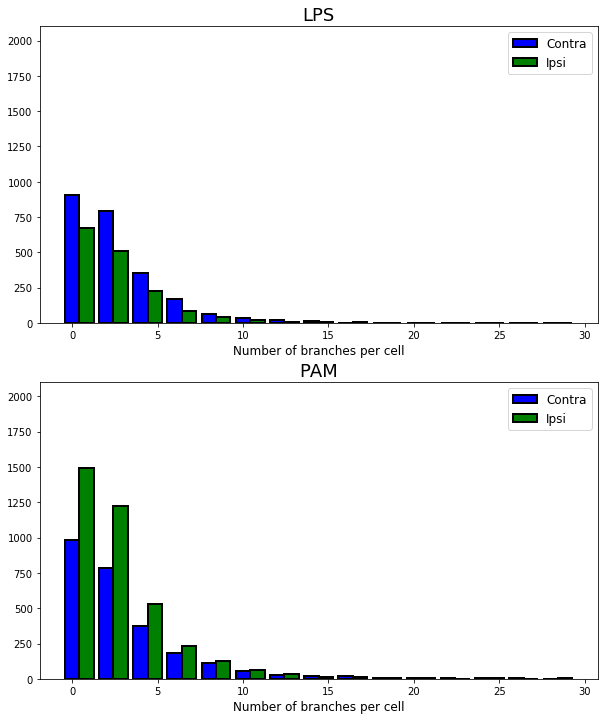

In [177]:
bins = np.linspace(0, 30, 16)
N = bins.shape[0]

fig, axes = plt.subplots(nrows=2, figsize=(10,12))

ind = np.arange(N-1)    # the x locations for the groups
width = 0.84       # the width of the bars
counter = 0

for ax in axes:
    mR, bins = np.histogram(mglias[(mglias['hemisphere']=='R') & (mglias['Injury']==types[counter])]['total_branches'],
                               bins=np.linspace(0, 30, 16))

    mL, bins = np.histogram(mglias[(mglias['hemisphere']=='L') & (mglias['Injury']==types[counter])]['total_branches'],
                               bins=np.linspace(0, 30, 16))

    
    p1 = ax.bar(ind*2, mR, width, color='b', bottom=0, edgecolor='k', linewidth=2)
    p2 = ax.bar(ind*2 + width, mL, width, color='g', bottom=0, edgecolor='k', linewidth=2)

    ax.set_title(types[counter], fontsize=18)
    ax.set_xlabel('Number of branches per cell', fontsize=12)
    #ax.set_xticks(ind + width / 2)
    #ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))
    ax.set_ylim([0, 2100])
    
    ax.legend((p1[0], p2[0]), ('Contra', 'Ipsi'), prop={'size': 12})
    
    counter = counter + 1

plt.show()

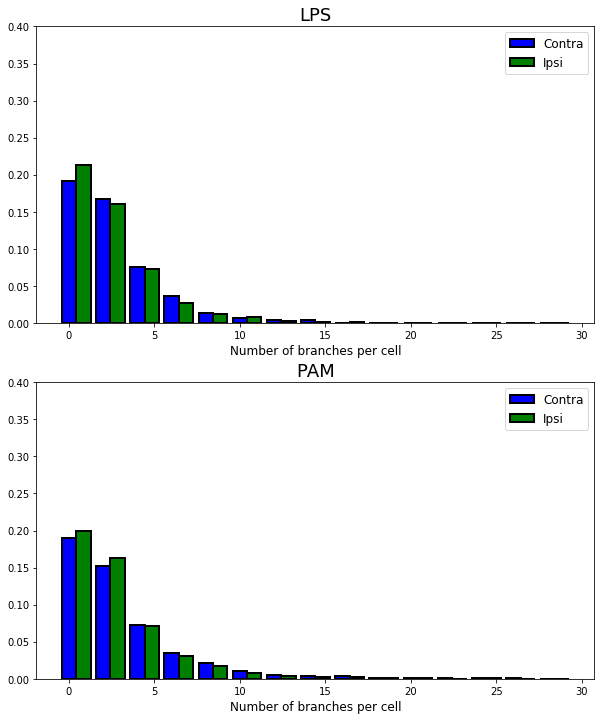

In [178]:
bins = np.linspace(0, 30, 16)
N = bins.shape[0]

fig, axes = plt.subplots(nrows=2, figsize=(10,12))

ind = np.arange(N-1)    # the x locations for the groups
width = 0.84       # the width of the bars
counter = 0

for ax in axes:
    mR, bins = np.histogram(mglias[(mglias['hemisphere']=='R') & (mglias['Injury']==types[counter])]['total_branches'],
                               bins=np.linspace(0, 30, 16), normed=True)

    mL, bins = np.histogram(mglias[(mglias['hemisphere']=='L') & (mglias['Injury']==types[counter])]['total_branches'],
                               bins=np.linspace(0, 30, 16), normed=True)

    
    p1 = ax.bar(ind*2, mR, width, color='b', bottom=0, edgecolor='k', linewidth=2)
    p2 = ax.bar(ind*2 + width, mL, width, color='g', bottom=0, edgecolor='k', linewidth=2)

    ax.set_title(types[counter], fontsize=18)
    ax.set_xlabel('Number of branches per cell', fontsize=12)
    #ax.set_xticks(ind + width / 2)
    #ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))
    ax.set_ylim([0, 0.4])
    
    ax.legend((p1[0], p2[0]), ('Contra', 'Ipsi'), prop={'size': 12})
    
    counter = counter + 1

plt.show()

In [ ]:
mPAML.shape

In [172]:
bins

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
       26., 28., 30.])